# Create a Bathymetry Surface Using Individual Scenes

An alternative approach to creating an image composite is to use each of the individual scenes, predict a bathymetric surface from each and the combine those results to create a single bathymetic surface. 

I prefer this method for the following reasons:

 1. Creating a composite of satellite imagery will often produce image artifacts which are then past through into any output products which are generated from that composite. 
 2. By having multiple estimates of the depth a per-pixel standard error surface can be calculated which provides an uncertainty surface which is useful for users of your bathymetric product.



# 1. Imports

In [1]:
import glob
import os

# Import Geopandas module
import geopandas

# Import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# import numpy module
import numpy

# import the pandas module
import pandas

# Import rsgislib modules
import rsgislib
import rsgislib.regression.regresssklearn
import rsgislib.tools.filetools
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.vectorutils.createrasters
import rsgislib.zonalstats

# Provided a local copy of the function as requires at least
# rsgislib v5.0.6 for the function drop_rows_by_attribute
# from rsgislib.vectorutils import drop_rows_by_attribute 
from vectorutils import drop_rows_by_attribute

# Use this import is you have rsgislib v5.0.0 to v5.0.4.
# the following import is a local version of the imagecomp file.
from plotting import cumulative_stretch_np_arr
# Use this rsgislib import is you have rsgislib v5.0.5 or higher.
# from rsgislib.tools.plotting import cumulative_stretch_np_arr

# Import Random Forests RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import joblib

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline




# 2. Define Input Datasets

In [2]:
# Get the input landsat image file paths.
landsat_imgs = glob.glob("../data/is2_bathy/ls_imgs/*.tif")

# The original ICESat-2 data.
is2_vec_file = "../data/is2_bathy/is2_bermuda_depth.gpkg"

# The land area vector layer for defining the valid area
land_area_vec_file = "../data/is2_bathy/bermuda_land_area.geojson"
land_area_vec_lyr = "bermuda_land_area"

# The ocean water area vector layer
ocean_area_vec_file = "../data/is2_bathy/bermuda_valid_water_mask.geojson"
ocean_area_vec_lyr = "bermuda_valid_water_mask"

out_dir = "ls_scns_outs"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

# 3. Merge ICESAT-2 Paths

The ICESat-2 data has been provided to you as a multi-layer vector file. For this analysis we want just a single vector layer so we do not have to repeat processing steps for the different layers. The following command merges the vector layers into a single layer.


In [3]:
is2_all_vec_file = os.path.join(out_dir, "is2_bermuda_depth_sgl_lyr_all.gpkg")
is2_all_vec_lyr = "is2_bermuda_depth_sgl_lyr_all"
rsgislib.vectorutils.merge_vector_lyrs_to_gpkg(
    is2_vec_file, is2_all_vec_file, is2_all_vec_lyr, exists=False
)

Processing: ic2_depth_bermuda_path2 has 3305 features.
Processing: ic2_depth_bermuda_path3 has 1840 features.
Processing: ic2_depth_bermuda_path4 has 5806 features.
Processing: ic2_depth_bermuda_path8 has 2344 features.
Processing: ic2_depth_bermuda_path5 has 4863 features.
Processing: ic2_depth_bermuda_path6 has 2301 features.
Processing: ic2_depth_bermuda_path7 has 5187 features.
Processing: ic2_depth_bermuda_path1 has 11380 features.


# 4. Extract Random Sample of ICESat-2 Returns

This step will extract a random 20 % sample of all the ICESat-2 returns and these will be used validate the final bathymetry surfaces. Given the large number of returns in the ICESat-2 data taking a sample to use as a validation dataset is a good idea as while k-fold and bootstrapping can be used to derieve statistics on the model accuracy it is ideal to have an independent dataset. 

In [4]:
is2_train_vec_file = os.path.join(out_dir, "is2_bermuda_depth_train.gpkg")
is2_train_vec_lyr = "is2_bermuda_depth_train"
is2_test_vec_file = os.path.join(out_dir, "is2_bermuda_depth_test.gpkg")
is2_test_vec_lyr = "is2_bermuda_depth_test"

rsgislib.vectorutils.create_train_test_smpls(
    is2_all_vec_file,
    is2_all_vec_lyr,
    is2_train_vec_file,
    is2_train_vec_lyr,
    is2_test_vec_file,
    is2_test_vec_lyr,
    out_format="GPKG",
    prop_test=0.2,
    tmp_dir="tmp",
    rnd_seed=42,
)

/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Number of Training Features: 29621
Number of Testing Features: 7405


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# 5. Check the Data Projections. 

A common error which can occur when combining datasets from different sources is that they are in different projections. 

In this case there are multiple input images so we need to loop through them all and check they each match the icesat-2 data.

In [5]:
is2_epsg = rsgislib.vectorutils.get_proj_epsg_from_vec(
    is2_vec_file, vec_lyr="ic2_depth_bermuda_path1"
)

# Iterate through the input images can check all having matching projections.
projects_match = True
for ls_img in landsat_imgs:
    ls_img_epsg = rsgislib.imageutils.get_epsg_proj_from_img(ls_img)

    if is2_epsg != ls_img_epsg:
        projects_match = False

if projects_match:
    print("Datasets have matching projections")
else:
    print("Projections DO NOT match - you probably need to sort something out here...")

Datasets have matching projections


# 6. Define the Valid Area to Apply the Model to

Before applying the model we need to define the area for which the model should be applied. For this analysis that will be over the areas of water so we need to mask the land area. You have been supplied a vector layer of the land area so lets use that to create a mask.

In [6]:
land_area_img = os.path.join(out_dir, "bermuda_land_area.kea")
rsgislib.vectorutils.createrasters.rasterise_vec_lyr(
    land_area_vec_file,
    land_area_vec_lyr,
    landsat_imgs[0],
    output_img=land_area_img,
    gdalformat="KEA",
    burn_val=1,
)

water_area_img = os.path.join(out_dir, "bermuda_water_area.kea")
rsgislib.imagecalc.image_math(
    land_area_img, water_area_img, "b1==1?0:1", "KEA", rsgislib.TYPE_8UINT
)
rsgislib.rastergis.pop_rat_img_stats(
    water_area_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



# 7. Iterate Through Landsat Images

For each scene the following analysis needs to be undertaken:

 1. Zonal statistics with the landsat reflectance values. This will done by reading the dataset into memory so a new points file will be created for each landsat image.
 2. Remove invalid icesat-2 points which do not have landsat reflectance values.
 3. Train regression algorithm
 4. Apply regression algorithm



In [7]:
bathy_imgs = list()
vld_msk_imgs = list()

for ls_img in landsat_imgs:
    ls_basename = rsgislib.tools.filetools.get_file_basename(ls_img)
    print(ls_basename)

    # Read vector layer to memory
    vec_ds_obj, vec_lyr_obj = rsgislib.vectorutils.read_vec_lyr_to_mem(
        is2_train_vec_file, is2_train_vec_lyr
    )

    # Zonal Stats for Coastal Band
    rsgislib.zonalstats.ext_point_band_values(
        vec_lyr_obj,
        ls_img,
        img_band=1,
        min_thres=-100,
        max_thres=10000,
        out_no_data_val=-9999,
        out_field="ls_coastal",
    )
    # Zonal Stats for Blue Band
    rsgislib.zonalstats.ext_point_band_values(
        vec_lyr_obj,
        ls_img,
        img_band=2,
        min_thres=-100,
        max_thres=10000,
        out_no_data_val=-9999,
        out_field="ls_blue",
    )
    # Zonal Stats for Green Band
    rsgislib.zonalstats.ext_point_band_values(
        vec_lyr_obj,
        ls_img,
        img_band=3,
        min_thres=-100,
        max_thres=10000,
        out_no_data_val=-9999,
        out_field="ls_green",
    )

    # Create output vector layer and file name
    vec_ls_stats_lyr = f"{ls_basename}_is2_pts"
    vec_ls_stats_file = os.path.join(out_dir, f"{vec_ls_stats_lyr}.gpkg")

    # Write vector layer to output file.
    rsgislib.vectorutils.write_vec_lyr_to_file(
        vec_lyr_obj,
        vec_ls_stats_file,
        vec_ls_stats_lyr,
        out_format="GPKG",
        replace=True,
    )

    is2_train_vld_vec_lyr = f"{ls_basename}_is2_pts_vld"
    is2_train_vld_vec_file = os.path.join(out_dir, f"{is2_train_vld_vec_lyr}.gpkg")

    # Check Coastal
    drop_rows_by_attribute(
        vec_file=vec_ls_stats_file,
        vec_lyr=vec_ls_stats_lyr,
        sub_col="ls_coastal",
        sub_vals=[-9999],
        out_vec_file=is2_train_vld_vec_file,
        out_vec_lyr=is2_train_vld_vec_lyr,
        out_format="GPKG",
    )

    # Check Blue - note the input and output files are now the same!
    drop_rows_by_attribute(
        vec_file=is2_train_vld_vec_file,
        vec_lyr=is2_train_vld_vec_lyr,
        sub_col="ls_blue",
        sub_vals=[-9999],
        out_vec_file=is2_train_vld_vec_file,
        out_vec_lyr=is2_train_vld_vec_lyr,
        out_format="GPKG",
    )

    # Check Green - note the input and output files are now the same!
    drop_rows_by_attribute(
        vec_file=is2_train_vld_vec_file,
        vec_lyr=is2_train_vld_vec_lyr,
        sub_col="ls_green",
        sub_vals=[-9999],
        out_vec_file=is2_train_vld_vec_file,
        out_vec_lyr=is2_train_vld_vec_lyr,
        out_format="GPKG",
    )

    # Open the GPKG file as a geopandas data frame - the gdf variable.
    gdf = geopandas.read_file(is2_train_vld_vec_file, layer=is2_train_vld_vec_lyr)

    # Get a list of the columns within the gdf dataframe
    cols = list(gdf.columns)

    print("All Columns: ", cols)

    # Get the indepedent predictor column names
    ind_vars = cols[6:9]

    # Get the depth column name
    depth_var = cols[4]

    print("Depth Variable: ", depth_var)
    print("Independent Variables: ", ind_vars)

    # Get the predictor variables and dependent variables
    # from the dataframe as numpy arrays
    x = gdf[ind_vars].values
    y = gdf[depth_var].values

    # Create a new regression object
    skregrs_obj = RandomForestRegressor()
    skregrs_obj.fit(x, y)

    # Create valid mask for the input image.
    vld_msk_img = os.path.join(out_dir, f"{ls_basename}_vld_msk.kea")
    rsgislib.imageutils.gen_valid_mask(
        ls_img, output_img=vld_msk_img, gdalformat="KEA", no_data_val=-9999
    )
    rsgislib.rastergis.pop_rat_img_stats(
        vld_msk_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
    )

    # Combine valid masks.
    water_area_vld_msk_img = os.path.join(out_dir, f"{ls_basename}_water_vld_msk.kea")
    band_defns = list()
    band_defns.append(rsgislib.imagecalc.BandDefn("vld", vld_msk_img, 1))
    band_defns.append(rsgislib.imagecalc.BandDefn("water", water_area_img, 1))
    rsgislib.imagecalc.band_math(
        water_area_vld_msk_img,
        "(vld==1)&&(water==1)?1:0",
        "KEA",
        rsgislib.TYPE_8UINT,
        band_defns,
    )
    rsgislib.rastergis.pop_rat_img_stats(
        water_area_vld_msk_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
    )

    # Apply regression to landsat image.
    bathy_depths_img = os.path.join(out_dir, f"{ls_basename}_bathy_rslt.kea")
    rsgislib.regression.regresssklearn.apply_regress_sklearn_mdl(
        skregrs_obj,
        1,
        ls_img,
        [1, 2, 3],
        water_area_vld_msk_img,
        1,
        bathy_depths_img,
        gdalformat="KEA",
        out_band_names=["Depth"],
        calc_stats=True,
        out_no_date_val=0.0,
    )
    bathy_imgs.append(bathy_depths_img)
    vld_msk_imgs.append(water_area_vld_msk_img)

lc08_l2sp_006038_20211021_20211103_02_t1_sref_sub_mskd


100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 91875.71it/s]


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']
0) ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20211021_20211103_02_t1_sref_sub_mskd.tif
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Image: ls_scns_outs/bermuda_water_area.kea
	 Variable 'water' is band 1
Image: ls_scns_outs/lc08_l2sp_006038_20211021_20211103_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Applying the Regression modelGet Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




  0%|          | 0/100 [00:00<?, ?it/s]

Completed

lc08_l2sp_006037_20150122_20200910_02_t1_sref_sub_mskd

Calculating Image Pyramids.




100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 89758.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 91996.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 91078.79it/s]


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']
0) ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20150122_20200910_02_t1_sref_sub_mskd.tif
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Image: ls_scns_outs/bermuda_water_area.kea
	 Variable 'water' is band 1
Image: ls_scns_outs/lc08_l2sp_006037_20150122_20200910_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Applying the Regression model


  0%|          | 0/100 [00:00<?, ?it/s]

Completed

lc08_l2sp_006037_20180623_20200831_02_t1_sref_sub_mskd

Calculating Image Pyramids.




100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 96018.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 99796.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 99181.40it/s]


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']
0) ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20180623_20200831_02_t1_sref_sub_mskd.tif
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Image: ls_scns_outs/bermuda_water_area.kea
	 Variable 'water' is band 1
Image: ls_scns_outs/lc08_l2sp_006037_20180623_20200831_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Applying the Regression modelGet Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




  0%|          | 0/100 [00:00<?, ?it/s]

Completed

lc08_l2sp_006038_20210802_20210811_02_t1_sref_sub_mskd

Calculating Image Pyramids.




100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 91580.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 92472.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 94569.31it/s]


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']
0) ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210802_20210811_02_t1_sref_sub_mskd.tif
Applying the Regression modelNew image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Image: ls_scns_outs/bermuda_water_area.kea
	 Variable 'water' is band 1
Image: ls_scns_outs/lc08_l2sp_006038_20210802_20210811_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




  0%|          | 0/100 [00:00<?, ?it/s]

Completed

lc08_l2sp_006038_20180522_20200901_02_t1_sref_sub_mskd

Calculating Image Pyramids.




100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 86840.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 88536.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 91245.41it/s]


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']
0) ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20180522_20200901_02_t1_sref_sub_mskd.tif
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Image: ls_scns_outs/bermuda_water_area.kea
	 Variable 'water' is band 1
Image: ls_scns_outs/lc08_l2sp_006038_20180522_20200901_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Applying the Regression modelGet Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




  0%|          | 0/100 [00:00<?, ?it/s]

Completed

lc08_l2sp_006038_20210311_20210317_02_t1_sref_sub_mskd
Calculating Image Pyramids.





100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 92204.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 93711.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 94144.57it/s]


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']
0) ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210311_20210317_02_t1_sref_sub_mskd.tif
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Image: ls_scns_outs/bermuda_water_area.kea
Applying the Regression model	 Variable 'water' is band 1
Image: ls_scns_outs/lc08_l2sp_006038_20210311_20210317_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




  0%|          | 0/100 [00:00<?, ?it/s]

Completed

lc08_l2sp_006038_20190829_20200826_02_t1_sref_sub_mskd

Calculating Image Pyramids.




100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 96523.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 99439.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 99494.18it/s]


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']
0) ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20190829_20200826_02_t1_sref_sub_mskd.tif
Applying the Regression model
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Image: ls_scns_outs/bermuda_water_area.kea
	 Variable 'water' is band 1
Image: ls_scns_outs/lc08_l2sp_006038_20190829_20200826_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



  0%|          | 0/100 [00:00<?, ?it/s]

Completed

lc09_l2sp_006038_20220101_20220123_02_t1_sref_sub_mskd

Calculating Image Pyramids.




100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 83156.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 91446.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 90279.03it/s]


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']
0) ../data/is2_bathy/ls_imgs/lc09_l2sp_006038_20220101_20220123_02_t1_sref_sub_mskd.tif
Applying the Regression modelNew image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Image: ls_scns_outs/bermuda_water_area.kea
	 Variable 'water' is band 1
Image: ls_scns_outs/lc09_l2sp_006038_20220101_20220123_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




  0%|          | 0/100 [00:00<?, ?it/s]

Completed

lc08_l2sp_006038_20170807_20200903_02_t1_sref_sub_mskd
Calculating Image Pyramids.





100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 90992.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 93928.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 91684.24it/s]


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']
0) ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170807_20200903_02_t1_sref_sub_mskd.tif
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Image: ls_scns_outs/bermuda_water_area.kea
	 Variable 'water' is band 1
Image: ls_scns_outs/lc08_l2sp_006038_20170807_20200903_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Applying the Regression modelGet Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




  0%|          | 0/100 [00:00<?, ?it/s]

Completed

lc08_l2sp_006038_20170417_20200904_02_t1_sref_sub_mskd
Calculating Image Pyramids.





100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 89026.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 91413.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 90269.06it/s]


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']
0) ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170417_20200904_02_t1_sref_sub_mskd.tif
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Image: ls_scns_outs/bermuda_water_area.kea
	 Variable 'water' is band 1
Image: ls_scns_outs/lc08_l2sp_006038_20170417_20200904_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Applying the Regression model


  0%|          | 0/100 [00:00<?, ?it/s]

Completed

lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd

Calculating Image Pyramids.




100%|██████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 106718.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 111905.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 29621/29621 [00:00<00:00, 110442.06it/s]


-9999
-9999


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


-9999
All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'ls_coastal', 'ls_blue', 'ls_green', 'geometry']
Depth Variable:  Depth
Independent Variables:  ['ls_coastal', 'ls_blue', 'ls_green']


/Users/pete/miniforge3/envs/osgeo-env-v3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


0) ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd.tif
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Applying the Regression modelImage: ls_scns_outs/bermuda_water_area.kea

	 Variable 'water' is band 1
Image: ls_scns_outs/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd_vld_msk.kea
	 Variable 'vld' is band 1
New image width = 1546 height = 1358 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



  0%|          | 0/100 [00:00<?, ?it/s]

Completed


Calculating Image Pyramids.



# 8. Merge Scene Outputs

In [8]:
# Calculate minimum bathymetric depth
bathy_depth_min_img = os.path.join(out_dir, "bermuda_bathy_min.kea")
rsgislib.imagecalc.calc_multi_img_band_stats(
    bathy_imgs,
    bathy_depth_min_img,
    rsgislib.SUMTYPE_MIN,
    "KEA",
    rsgislib.TYPE_32FLOAT,
    0.0,
    True,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_min_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

# Calculate maximum bathymetric depth
bathy_depth_max_img = os.path.join(out_dir, "bermuda_bathy_max.kea")
rsgislib.imagecalc.calc_multi_img_band_stats(
    bathy_imgs,
    bathy_depth_max_img,
    rsgislib.SUMTYPE_MAX,
    "KEA",
    rsgislib.TYPE_32FLOAT,
    0.0,
    True,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_max_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

# Calculate mean bathymetric depth
bathy_depth_mean_img = os.path.join(out_dir, "bermuda_bathy_mean.kea")
rsgislib.imagecalc.calc_multi_img_band_stats(
    bathy_imgs,
    bathy_depth_mean_img,
    rsgislib.SUMTYPE_MEAN,
    "KEA",
    rsgislib.TYPE_32FLOAT,
    0.0,
    True,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_mean_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

# Calculate median bathymetric depth
bathy_depth_median_img = os.path.join(out_dir, "bermuda_bathy_median.kea")
rsgislib.imagecalc.calc_multi_img_band_stats(
    bathy_imgs,
    bathy_depth_median_img,
    rsgislib.SUMTYPE_MEDIAN,
    "KEA",
    rsgislib.TYPE_32FLOAT,
    0.0,
    True,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_median_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

# Calculate std dev bathymetric depth
bathy_depth_stdev_img = os.path.join(out_dir, "bermuda_bathy_stdev.kea")
rsgislib.imagecalc.calc_multi_img_band_stats(
    bathy_imgs,
    bathy_depth_stdev_img,
    rsgislib.SUMTYPE_STDDEV,
    "KEA",
    rsgislib.TYPE_32FLOAT,
    0.0,
    True,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_stdev_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

# Calculate the count of the number of observations
bathy_depth_count_img = os.path.join(out_dir, "bermuda_bathy_count.kea")
rsgislib.imagecalc.calc_multi_img_band_stats(
    vld_msk_imgs,
    bathy_depth_count_img,
    rsgislib.SUMTYPE_SUM,
    "KEA",
    rsgislib.TYPE_8UINT,
    0.0,
    True,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_count_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

Opening ls_scns_outs/lc08_l2sp_006038_20211021_20211103_02_t1_sref_sub_mskd_bathy_rslt.kea
Opening ls_scns_outs/lc08_l2sp_006037_20150122_20200910_02_t1_sref_sub_mskd_bathy_rslt.kea
Opening ls_scns_outs/lc08_l2sp_006037_20180623_20200831_02_t1_sref_sub_mskd_bathy_rslt.kea
Opening ls_scns_outs/lc08_l2sp_006038_20210802_20210811_02_t1_sref_sub_mskd_bathy_rslt.kea
Opening ls_scns_outs/lc08_l2sp_006038_20180522_20200901_02_t1_sref_sub_mskd_bathy_rslt.kea
Opening ls_scns_outs/lc08_l2sp_006038_20210311_20210317_02_t1_sref_sub_mskd_bathy_rslt.kea
Opening ls_scns_outs/lc08_l2sp_006038_20190829_20200826_02_t1_sref_sub_mskd_bathy_rslt.kea
Opening ls_scns_outs/lc09_l2sp_006038_20220101_20220123_02_t1_sref_sub_mskd_bathy_rslt.kea
Opening ls_scns_outs/lc08_l2sp_006038_20170807_20200903_02_t1_sref_sub_mskd_bathy_rslt.kea
Opening ls_scns_outs/lc08_l2sp_006038_20170417_20200904_02_t1_sref_sub_mskd_bathy_rslt.kea
Opening ls_scns_outs/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd_bathy_rslt.kea

# 9. Calculate the Standard Error

Standard deviation and standard error are both used in all types of statistical studies. In these studies, the standard deviation and the estimated standard error are used to present the characteristics of sample data and explain statistical analysis results.

However, some researchers occasionally confuse the standard deviation and the standard error. Such researchers should remember that the calculations for standard deviation and standard error include different statistical inferences, each of them with its own meaning. Standard deviation is the dispersion of individual data values. In other words, standard deviation indicates how accurately the mean represents sample data. While the meaning of standard error includes statistical inference based on the sampling distribution. Standard error is the standard deviation of the theoretical distribution of the sample means (the sampling distribution).


In [9]:
# Calculate standard error bathymetric depth
bathy_depth_stderr_img = os.path.join(out_dir, "bermuda_bathy_std_err.kea")

band_defns = list()
band_defns.append(rsgislib.imagecalc.BandDefn("std", bathy_depth_stdev_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("n", bathy_depth_count_img, 1))
rsgislib.imagecalc.band_math(
    bathy_depth_stderr_img,
    "n>0?std/sqrt(n):0",
    "KEA",
    rsgislib.TYPE_32FLOAT,
    band_defns,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_stderr_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

Image: ls_scns_outs/bermuda_bathy_count.kea
	 Variable 'n' is band 1
Image: ls_scns_outs/bermuda_bathy_stdev.kea
	 Variable 'std' is band 1
New image width = 1546 height = 1358 bands = 1



Calculating Image Pyramids.



# 10. Visualise Results

It is highly recommended that you also open these images in TuiView and have a proper look at the data. What artifacts do you see? What are the pixels values? How do they compare?


Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358


/var/folders/9p/p61100rs001_g5d8069gvzcm0000gn/T/ipykernel_83053/3383339495.py:20: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  mcolors.Colormap.set_under(cmap, color="white")
/var/folders/9p/p61100rs001_g5d8069gvzcm0000gn/T/ipykernel_83053/3383339495.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  mcolors.Colormap.set_over(cmap, color="white")


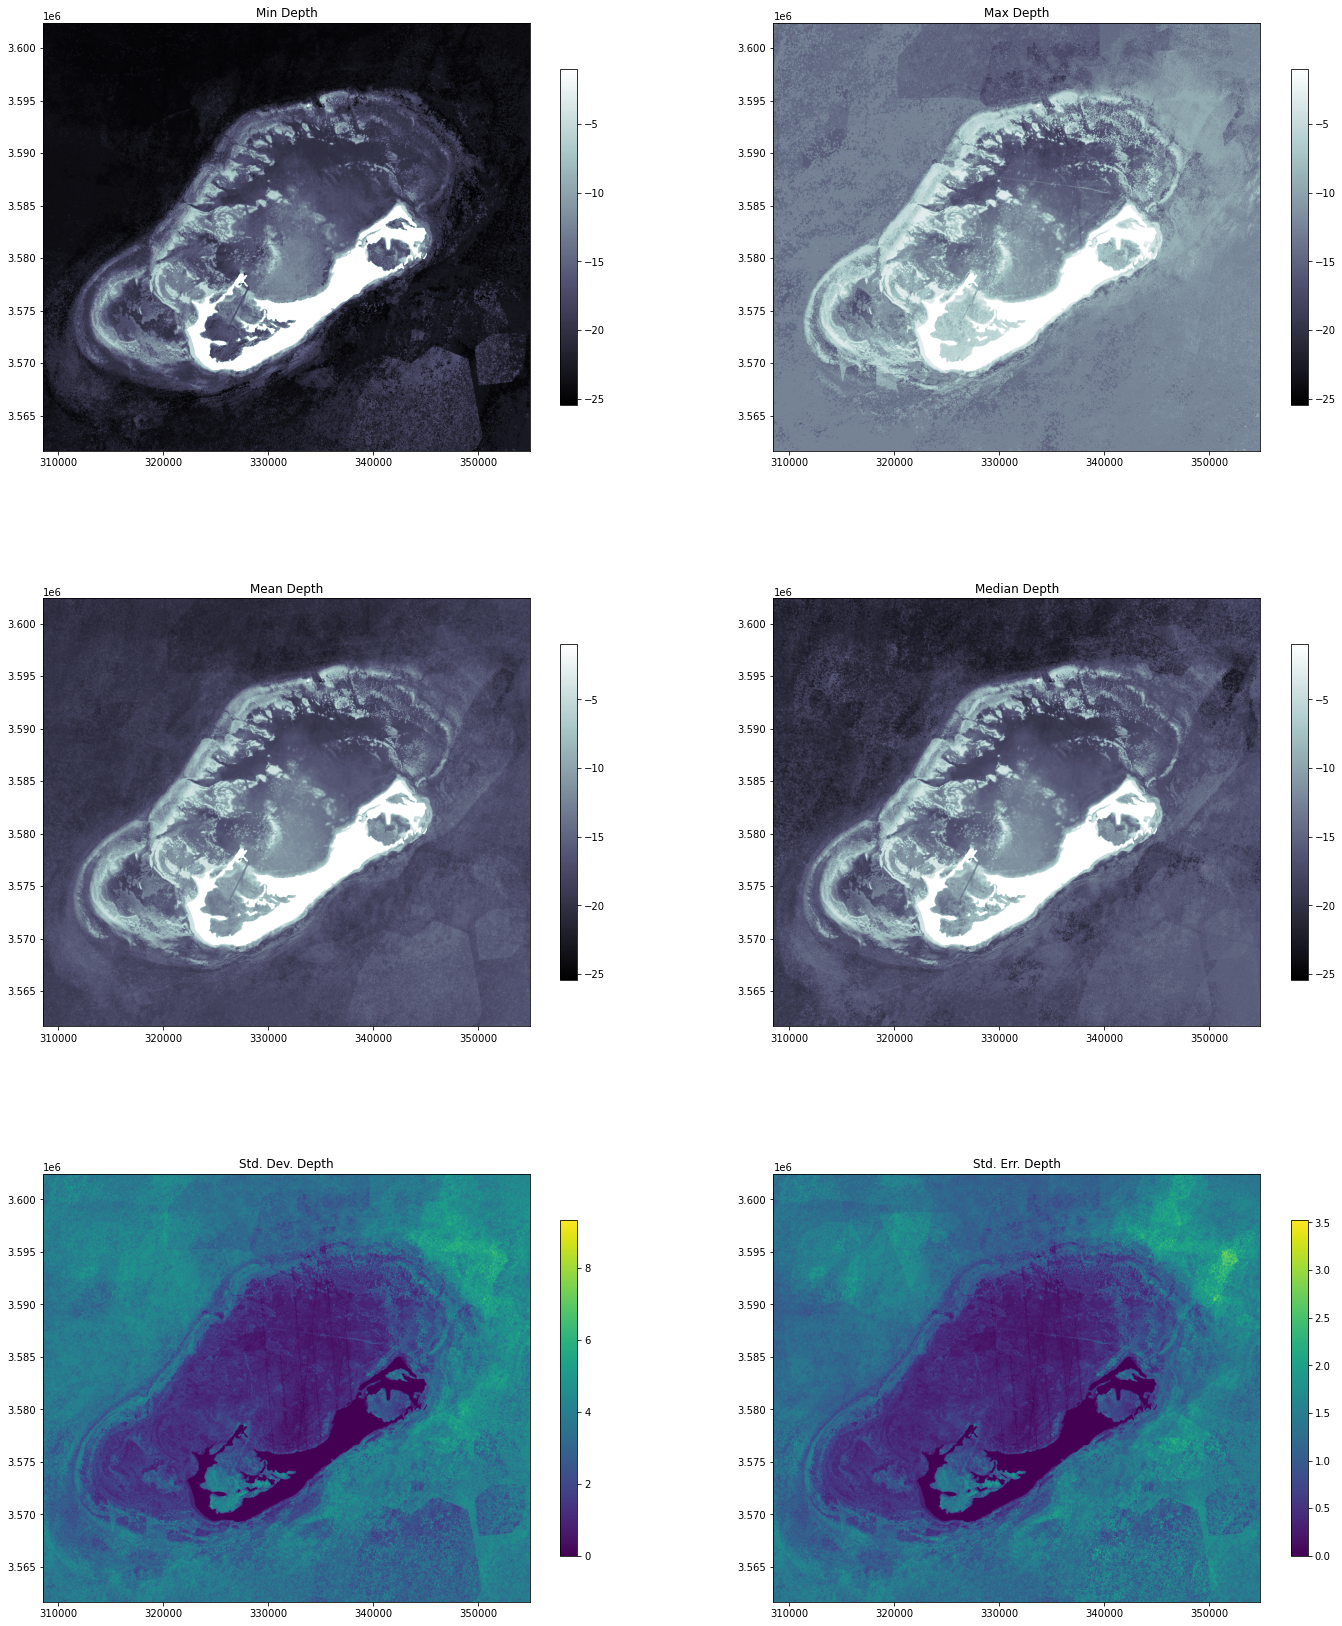

In [10]:
# Get the image data - min
(
    img_bathy_min_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(bathy_depth_min_img, bands=[1])

# Get the image data - max
(
    img_bathy_max_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(bathy_depth_max_img, bands=[1])

# Get the image data - mean
(
    img_bathy_mean_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(bathy_depth_mean_img, bands=[1])

# Get the image data - median
(
    img_bathy_med_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    bathy_depth_median_img, bands=[1]
)

# Get the image data - std dev
(
    img_bathy_stdev_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(bathy_depth_stdev_img, bands=[1])

# Get the image data - std err
(
    img_bathy_stderr_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    bathy_depth_stderr_img, bands=[1]
)

cmap = plt.get_cmap("bone")
mcolors.Colormap.set_under(cmap, color="white")
mcolors.Colormap.set_over(cmap, color="white")

c_norm = mcolors.Normalize(vmax=-1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 30))

dpt_min_plt = ax1.imshow(
    img_bathy_min_data, extent=img_bathy_coords, cmap=cmap, norm=c_norm
)
ax1.title.set_text("Min Depth")
fig.colorbar(dpt_min_plt, ax=ax1, orientation="vertical", shrink=0.7)

dpt_max_plt = ax2.imshow(
    img_bathy_max_data, extent=img_bathy_coords, cmap=cmap, norm=c_norm
)
ax2.title.set_text("Max Depth")
fig.colorbar(dpt_max_plt, ax=ax2, orientation="vertical", shrink=0.7)


dpt_mean_plt = ax3.imshow(
    img_bathy_mean_data, extent=img_bathy_coords, cmap=cmap, norm=c_norm
)
ax3.title.set_text("Mean Depth")
fig.colorbar(dpt_mean_plt, ax=ax3, orientation="vertical", shrink=0.7)

dpt_median_plt = ax4.imshow(
    img_bathy_med_data, extent=img_bathy_coords, cmap=cmap, norm=c_norm
)
ax4.title.set_text("Median Depth")
fig.colorbar(dpt_median_plt, ax=ax4, orientation="vertical", shrink=0.7)

dpt_stdev_plt = ax5.imshow(img_bathy_stdev_data, extent=img_bathy_coords)
ax5.title.set_text("Std. Dev. Depth")
fig.colorbar(dpt_stdev_plt, ax=ax5, orientation="vertical", shrink=0.7)

dpt_stderr_plt = ax6.imshow(img_bathy_stderr_data, extent=img_bathy_coords)
ax6.title.set_text("Std. Err. Depth")
fig.colorbar(dpt_stderr_plt, ax=ax6, orientation="vertical", shrink=0.7)

## 10.1 So, what can we see in these images?

The first thing to note is that the minimum depth is the deepest value (i.e., further away from water surface) while the maximum is the shadowist pixels (i.e., closest to water surface).

The min and max values are sensitive to extreme values so the mean and median tend to be the better results. In this case, the result looks pretty similar for the mean and median but if there is more noise (e.g., missed cloud in some of the input images) then you will probably find the median is a better result with less artifacts. 

The standard deviation and standard error images look pretty similar but you can see that the further from the icesat-2 paths the values are increasing and you can see that particularly in the areas of deep water that the values are significantly higher as there is little or no training data in these areas. You can even see the locations of the icesat-2 paths which have been used for training as these have produced very similar values for the depth from each scene as those pixels were included in the training. 


# 11. Mask to the Valid Area

This could have been done before the analysis and merged with the valid mask which was passed to the apply_regress_sklearn_mdl function. However, for illustration purposes it was useful to have the standard deviation and standard error values for the wider region. We will therefore apply the mask to all the images now. 


In [11]:
ocean_area_img = os.path.join(out_dir, "bermuda_ocean_area.kea")
rsgislib.vectorutils.createrasters.rasterise_vec_lyr(
    ocean_area_vec_file,
    ocean_area_vec_lyr,
    landsat_imgs[0],
    output_img=ocean_area_img,
    gdalformat="KEA",
    burn_val=1,
)

Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



In [12]:
rsgislib.imageutils.set_env_vars_lzw_gtiff_outs()

# Mask minimum bathymetric depth
bathy_depth_min_fnl_img = os.path.join(out_dir, "bermuda_bathy_min.tif")
rsgislib.imageutils.mask_img(
    bathy_depth_min_img,
    ocean_area_img,
    bathy_depth_min_fnl_img,
    "GTIFF",
    rsgislib.TYPE_32FLOAT,
    0,
    1,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_min_fnl_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

# Mask maximum bathymetric depth
bathy_depth_max_fnl_img = os.path.join(out_dir, "bermuda_bathy_max.tif")
rsgislib.imageutils.mask_img(
    bathy_depth_max_img,
    ocean_area_img,
    bathy_depth_max_fnl_img,
    "GTIFF",
    rsgislib.TYPE_32FLOAT,
    0,
    1,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_max_fnl_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

# Mask mean bathymetric depth
bathy_depth_mean_fnl_img = os.path.join(out_dir, "bermuda_bathy_mean.tif")
rsgislib.imageutils.mask_img(
    bathy_depth_mean_img,
    ocean_area_img,
    bathy_depth_mean_fnl_img,
    "GTIFF",
    rsgislib.TYPE_32FLOAT,
    0,
    1,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_mean_fnl_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

# Mask median bathymetric depth
bathy_depth_median_fnl_img = os.path.join(out_dir, "bermuda_bathy_median.tif")
rsgislib.imageutils.mask_img(
    bathy_depth_median_img,
    ocean_area_img,
    bathy_depth_median_fnl_img,
    "GTIFF",
    rsgislib.TYPE_32FLOAT,
    0,
    1,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_median_fnl_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

# Mask std dev bathymetric depth
bathy_depth_stdev_fnl_img = os.path.join(out_dir, "bermuda_bathy_stdev.tif")
rsgislib.imageutils.mask_img(
    bathy_depth_stdev_img,
    ocean_area_img,
    bathy_depth_stdev_fnl_img,
    "GTIFF",
    rsgislib.TYPE_32FLOAT,
    0,
    1,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_stdev_fnl_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

# Mask std err bathymetric depth
bathy_depth_stderr_fnl_img = os.path.join(out_dir, "bermuda_bathy_std_err.tif")
rsgislib.imageutils.mask_img(
    bathy_depth_stderr_img,
    ocean_area_img,
    bathy_depth_stderr_fnl_img,
    "GTIFF",
    rsgislib.TYPE_32FLOAT,
    0,
    1,
)
rsgislib.imageutils.pop_img_stats(
    bathy_depth_stderr_fnl_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

New image width = 1546 height = 1358 bands = 1



Calculating Image Pyramids.


New image width = 1546 height = 1358 bands = 1



Calculating Image Pyramids.


New image width = 1546 height = 1358 bands = 1



Calculating Image Pyramids.


New image width = 1546 height = 1358 bands = 1



Calculating Image Pyramids.


New image width = 1546 height = 1358 bands = 1



Calculating Image Pyramids.


New image width = 1546 height = 1358 bands = 1



Calculating Image Pyramids.




## 11.1 Visualise the Masked Images

Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358


/var/folders/9p/p61100rs001_g5d8069gvzcm0000gn/T/ipykernel_83053/1312756462.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  mcolors.Colormap.set_under(cmap, color="white")
/var/folders/9p/p61100rs001_g5d8069gvzcm0000gn/T/ipykernel_83053/1312756462.py:22: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  mcolors.Colormap.set_over(cmap, color="white")


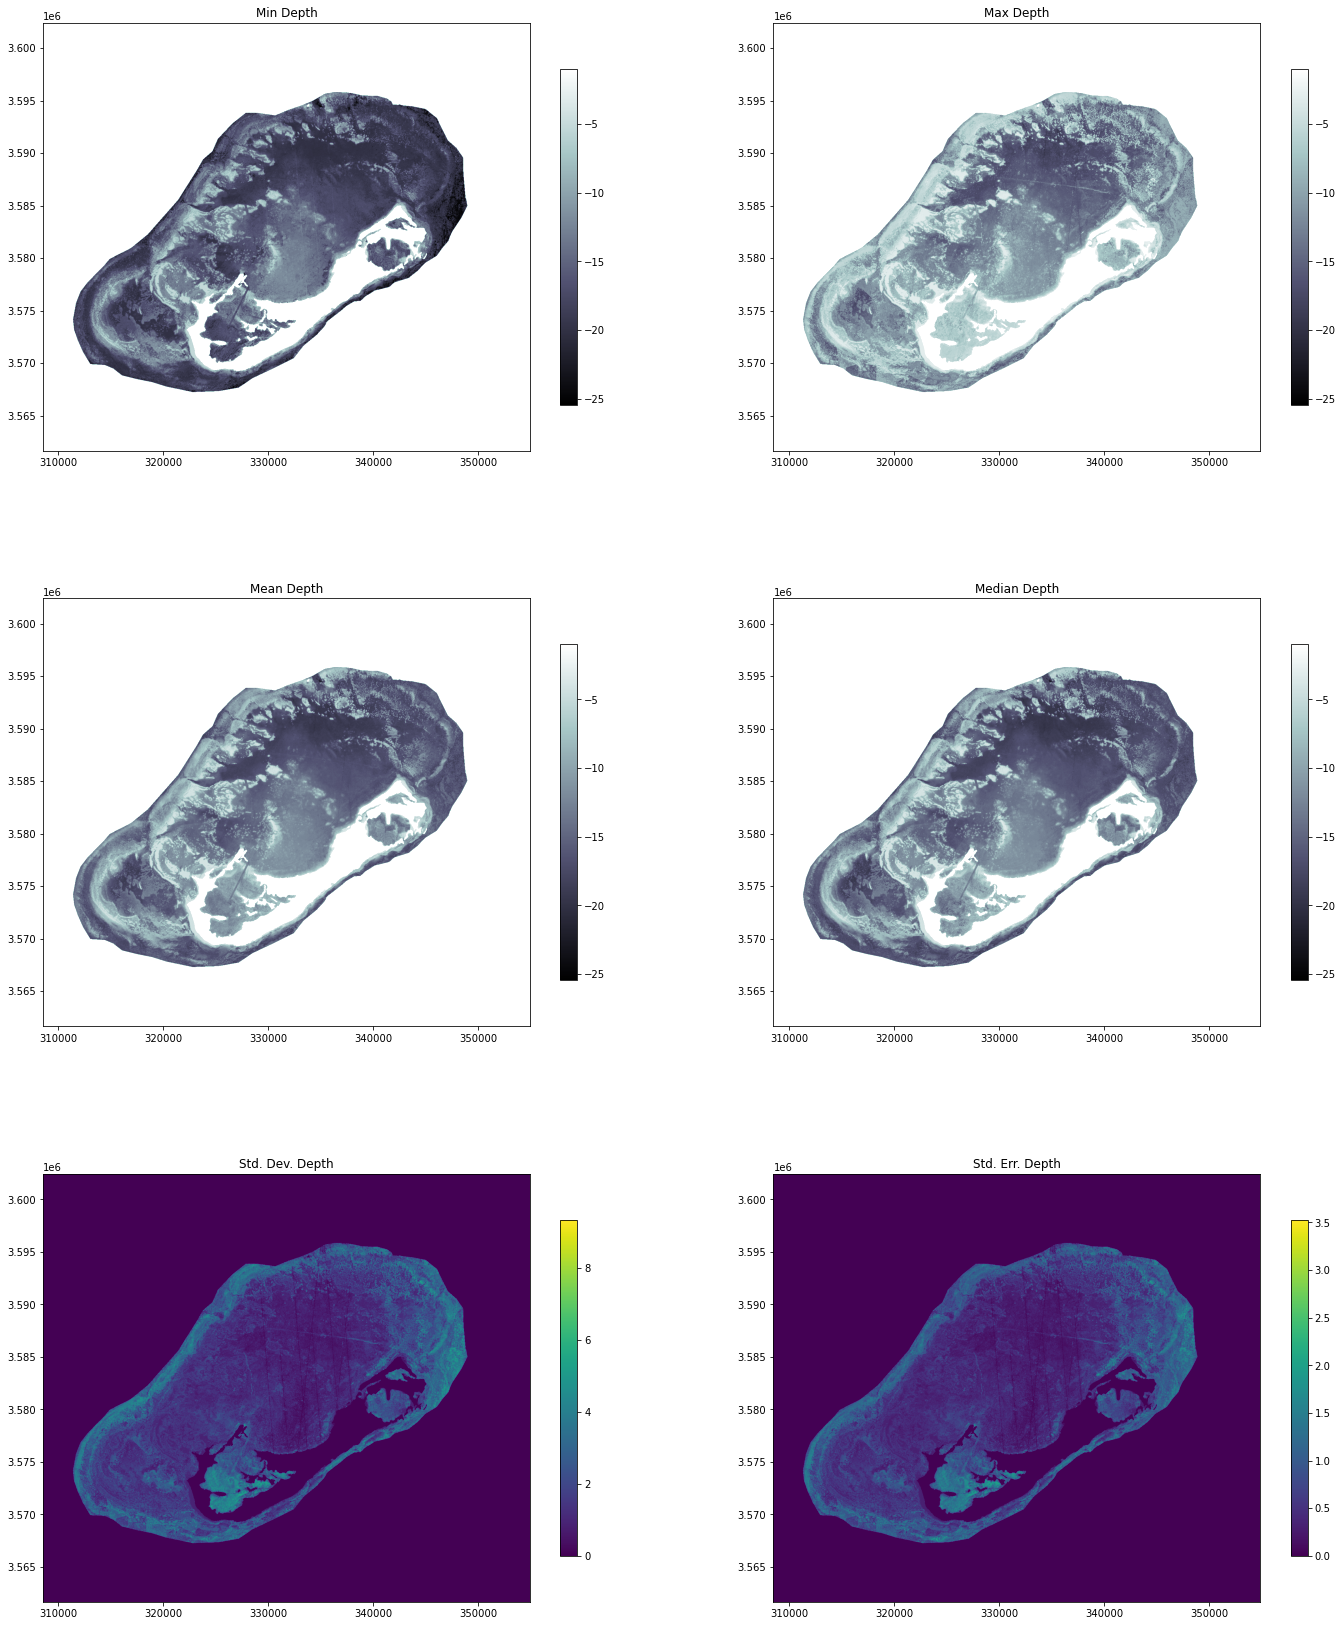

In [13]:
# Get the image data - min
(
    img_bathy_min_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    bathy_depth_min_fnl_img, bands=[1]
)

# Get the image data - max
(
    img_bathy_max_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    bathy_depth_max_fnl_img, bands=[1]
)

# Get the image data - mean
(
    img_bathy_mean_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    bathy_depth_mean_fnl_img, bands=[1]
)

# Get the image data - median
(
    img_bathy_med_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    bathy_depth_median_fnl_img, bands=[1]
)

# Get the image data - std dev
(
    img_bathy_stdev_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    bathy_depth_stdev_fnl_img, bands=[1]
)

# Get the image data - std err
(
    img_bathy_stderr_data,
    img_bathy_coords,
) = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    bathy_depth_stderr_fnl_img, bands=[1]
)


cmap = plt.get_cmap("bone")
mcolors.Colormap.set_under(cmap, color="white")
mcolors.Colormap.set_over(cmap, color="white")

c_norm = mcolors.Normalize(vmax=-1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 30))

dpt_min_plt = ax1.imshow(
    img_bathy_min_data, extent=img_bathy_coords, cmap=cmap, norm=c_norm
)
ax1.title.set_text("Min Depth")
fig.colorbar(dpt_min_plt, ax=ax1, orientation="vertical", shrink=0.7)

dpt_max_plt = ax2.imshow(
    img_bathy_max_data, extent=img_bathy_coords, cmap=cmap, norm=c_norm
)
ax2.title.set_text("Max Depth")
fig.colorbar(dpt_max_plt, ax=ax2, orientation="vertical", shrink=0.7)


dpt_mean_plt = ax3.imshow(
    img_bathy_mean_data, extent=img_bathy_coords, cmap=cmap, norm=c_norm
)
ax3.title.set_text("Mean Depth")
fig.colorbar(dpt_mean_plt, ax=ax3, orientation="vertical", shrink=0.7)

dpt_median_plt = ax4.imshow(
    img_bathy_med_data, extent=img_bathy_coords, cmap=cmap, norm=c_norm
)
ax4.title.set_text("Median Depth")
fig.colorbar(dpt_median_plt, ax=ax4, orientation="vertical", shrink=0.7)

dpt_stdev_plt = ax5.imshow(img_bathy_stdev_data, extent=img_bathy_coords)
ax5.title.set_text("Std. Dev. Depth")
fig.colorbar(dpt_stdev_plt, ax=ax5, orientation="vertical", shrink=0.7)

dpt_stderr_plt = ax6.imshow(img_bathy_stderr_data, extent=img_bathy_coords)
ax6.title.set_text("Std. Err. Depth")
fig.colorbar(dpt_stderr_plt, ax=ax6, orientation="vertical", shrink=0.7)

# 12. Assess the Quality of the Result

## 12.1 Perform Zonal Stats

In [14]:
# Perform Zonal Statistics for the predicted depth
rsgislib.zonalstats.ext_point_band_values_file(
    is2_test_vec_file,
    is2_test_vec_lyr,
    bathy_depth_min_fnl_img,
    img_band=1,
    min_thres=-50,
    max_thres=1,
    out_no_data_val=9999,
    out_field="min_depth",
)
rsgislib.zonalstats.ext_point_band_values_file(
    is2_test_vec_file,
    is2_test_vec_lyr,
    bathy_depth_max_fnl_img,
    img_band=1,
    min_thres=-50,
    max_thres=1,
    out_no_data_val=9999,
    out_field="max_depth",
)
rsgislib.zonalstats.ext_point_band_values_file(
    is2_test_vec_file,
    is2_test_vec_lyr,
    bathy_depth_mean_fnl_img,
    img_band=1,
    min_thres=-50,
    max_thres=1,
    out_no_data_val=9999,
    out_field="mean_depth",
)
rsgislib.zonalstats.ext_point_band_values_file(
    is2_test_vec_file,
    is2_test_vec_lyr,
    bathy_depth_median_fnl_img,
    img_band=1,
    min_thres=-50,
    max_thres=1,
    out_no_data_val=9999,
    out_field="median_depth",
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7405/7405 [00:00<00:00, 35522.39it/s]


In [15]:
# Open the GPKG file as a geopandas data frame - the gdf variable.
gdf = geopandas.read_file(is2_test_vec_file, layer=is2_test_vec_lyr)

# Get a list of the columns within the gdf dataframe
cols = list(gdf.columns)

print("All Columns: ", cols)

vld_min_gpdf = gdf.drop(gdf[gdf["min_depth"] == 9999].index)
min_depth_ref = vld_min_gpdf["Depth"].values
min_depth_pred = vld_min_gpdf["min_depth"].values

vld_max_gpdf = gdf.drop(gdf[gdf["max_depth"] == 9999].index)
max_depth_ref = vld_min_gpdf["Depth"].values
max_depth_pred = vld_min_gpdf["max_depth"].values

vld_mean_gpdf = gdf.drop(gdf[gdf["mean_depth"] == 9999].index)
mean_depth_ref = vld_min_gpdf["Depth"].values
mean_depth_pred = vld_min_gpdf["mean_depth"].values

vld_median_gpdf = gdf.drop(gdf[gdf["median_depth"] == 9999].index)
median_depth_ref = vld_min_gpdf["Depth"].values
median_depth_pred = vld_min_gpdf["median_depth"].values

All Columns:  ['field_1', 'Longitude', 'Latitude', 'PhotonHeig', 'Depth', 'LandConfid', 'min_depth', 'max_depth', 'mean_depth', 'median_depth', 'geometry']


## 12.2 Plot Reference v Predicted

Text(0.5, 0, 'Reference Depth (m)')

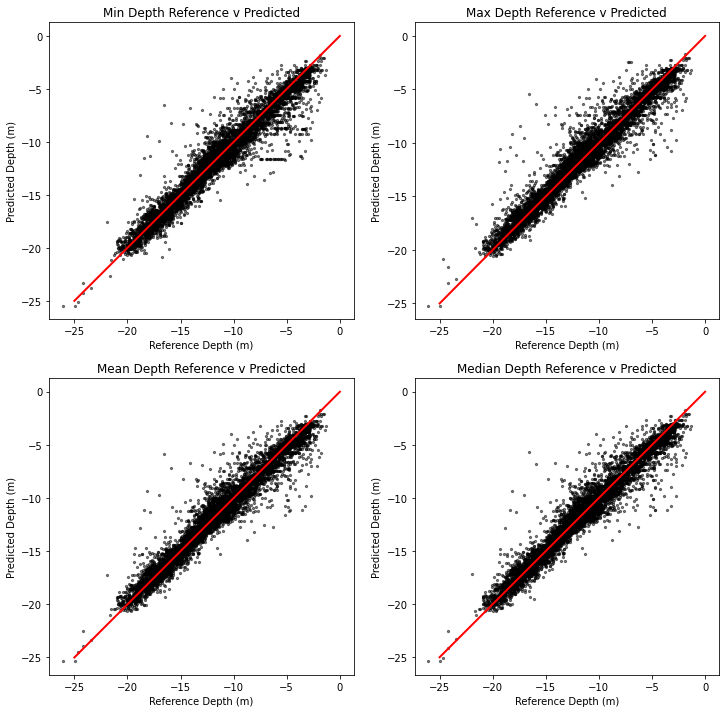

In [16]:
# Create the matplotlib figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

ax1.scatter(min_depth_ref, min_depth_pred, s=5, marker="o", color="black", alpha=0.5)
ax1.plot([-25, 0], [-25, 0], color="red", linestyle="-", linewidth=2)
ax1.title.set_text("Min Depth Reference v Predicted")
ax1.set_ylabel("Predicted Depth (m)")
ax1.set_xlabel("Reference Depth (m)")

ax2.scatter(max_depth_ref, max_depth_pred, s=5, marker="o", color="black", alpha=0.5)
ax2.plot([-25, 0], [-25, 0], color="red", linestyle="-", linewidth=2)
ax2.title.set_text("Max Depth Reference v Predicted")
ax2.set_ylabel("Predicted Depth (m)")
ax2.set_xlabel("Reference Depth (m)")

ax3.scatter(mean_depth_ref, mean_depth_pred, s=5, marker="o", color="black", alpha=0.5)
ax3.plot([-25, 0], [-25, 0], color="red", linestyle="-", linewidth=2)
ax3.title.set_text("Mean Depth Reference v Predicted")
ax3.set_ylabel("Predicted Depth (m)")
ax3.set_xlabel("Reference Depth (m)")

ax4.scatter(
    median_depth_ref, median_depth_pred, s=5, marker="o", color="black", alpha=0.5
)
ax4.plot([-25, 0], [-25, 0], color="red", linestyle="-", linewidth=2)
ax4.title.set_text("Median Depth Reference v Predicted")
ax4.set_ylabel("Predicted Depth (m)")
ax4.set_xlabel("Reference Depth (m)")

## 12.3 Calculate Quality Statistics

In [17]:
reg_min_stats = rsgislib.regression.get_regression_stats(
    min_depth_ref, min_depth_pred, n_vars=1
)
reg_max_stats = rsgislib.regression.get_regression_stats(
    max_depth_ref, max_depth_pred, n_vars=1
)
reg_mean_stats = rsgislib.regression.get_regression_stats(
    mean_depth_ref, mean_depth_pred, n_vars=1
)
reg_median_stats = rsgislib.regression.get_regression_stats(
    median_depth_ref, median_depth_pred, n_vars=1
)

In [18]:
# Create a dictionary to populate with data
# for building a pandas dataframe.
reg_stats = dict()
for key in reg_min_stats[0]:
    reg_stats[key] = list()

In [19]:
# Create a list of names (will be index to pandas dataframe)
stats_names = ["Min", "Max", "Mean", "Median"]
# Create a dict of the stats so they can be iterated through
stats_dict = dict()
stats_dict["Min"] = reg_min_stats[0]
stats_dict["Max"] = reg_max_stats[0]
stats_dict["Mean"] = reg_mean_stats[0]
stats_dict["Median"] = reg_median_stats[0]

In [20]:
# Iterate through the stats dict and poplulate structure
#  for building the dataframe.
for stat_name in stats_names:
    for key in stats_dict[stat_name]:
        reg_stats[key].append(stats_dict[stat_name][key])

In [21]:
reg_stats_df = pandas.DataFrame.from_dict(
    reg_stats, orient="index", columns=stats_names
).T
reg_stats_df

,r2,explained_variance_score,median_absolute_error,mean_absolute_error,mean_squared_error,root_mean_squared_error,norm_root_mean_squared_error,bias,norm_bias,bias_squared,variance,noise
Min,0.935784,0.936323,0.483059,0.728255,1.267435,1.125804,-9.803382,-0.103180,0.898483,0.010646,1.256789,0.000000e+00
Max,0.940094,0.940631,0.472364,0.704024,1.182369,1.087368,-9.468686,0.102983,-0.896766,0.010606,1.171764,0.000000e+00
Mean,0.946336,0.946342,0.469818,0.681240,1.059169,1.029159,-8.961811,0.011220,-0.097705,0.000126,1.059043,0.000000e+00
Median,0.946637,0.946650,0.464604,0.678152,1.053231,1.026271,-8.936655,0.015985,-0.139198,0.000256,1.052976,2.220446e-16


In [22]:
# Save to a CSV file so they can be openned as a spreadsheet.
quality_stats_file = os.path.join(out_dir, "bermuda_bathy_quality_stats.csv")
reg_stats_df.to_csv(quality_stats_file)

## 12.4 What do these stats show?

I would start by looking at the r2, RMSE and nRMSE where we can see the mean and median have higher r2 values and lower RMSE and nRMSE values which suggests that these are better results, which is probably what we would expect. Comparing the mean and median the values are very close but the median is slightly better. 

Additionally, we can also compare to the landsat composite result and compared to this we find that both the mean and median have produced a better result. The r2 from the composite was 0.93 compared to 0.95, while the composite RMSE was 1.18 compared to 1.03 and the nRMSE for the composite was -10.2% compared with -8.9. The difference is not significant but it does show a small improvement. You might have this improves further if the input imagery had more noise. 

## 12.5 Residuals Analysis for Mean

In [23]:
depth_mean_residuals = mean_depth_ref - mean_depth_pred

bathy_resid_plt_file = os.path.join(out_dir, "bermuda_bathy_mean_residuals.png")
rsgislib.tools.plotting.residual_plot(
    mean_depth_ref,
    depth_mean_residuals,
    bathy_resid_plt_file,
    title="Residuals for Mean Bathymetry Depths",
)

In [24]:
depth_resid_qq_plt_file = os.path.join(out_dir, "bermuda_bathy_mean_residuals_qq.png")
rsgislib.tools.plotting.quantile_plot(
    depth_mean_residuals,
    "Depth error (m)",
    depth_resid_qq_plt_file,
    title="Residuals for Mean Bathymetric Depths",
)

![Depth Mean Residuals](figures/bermuda_bathy_mean_residuals.png)
![Depth Mean Residuals QQ](figures/bermuda_bathy_mean_residuals_qq.png)

## 12.6 Residuals Analysis for Median

In [25]:
depth_median_residuals = median_depth_ref - median_depth_pred

bathy_resid_plt_file = os.path.join(out_dir, "bermuda_bathy_median_residuals.png")
rsgislib.tools.plotting.residual_plot(
    median_depth_ref,
    depth_median_residuals,
    bathy_resid_plt_file,
    title="Residuals for Median Bathymetry Depths",
)

In [26]:
depth_resid_qq_plt_file = os.path.join(out_dir, "bermuda_bathy_median_residuals_qq.png")
rsgislib.tools.plotting.quantile_plot(
    depth_median_residuals,
    "Depth error (m)",
    depth_resid_qq_plt_file,
    title="Residuals for Median Bathymetric Depths",
)

![Depth Median Residuals](figures/bermuda_bathy_median_residuals.png)
![Depth Median Residuals QQ](figures/bermuda_bathy_median_residuals_qq.png)

# 13. Final Comments

In this case there isn't a significant difference in the residuals of the mean or median summary and the statistics summarises are both very similar. Therefore, in choosing the produce to make available I would look at them and see if you find any significant differences between the two images and if those differences might justify choosing one over another. However, if like in this case, there is genuinely very difference between them then I would generally go for the median as it is more robust to noise. 

For the example show in these notebooks there is very little difference between using a satellite image composite or summarising the products from multiple input scenes. However, I would recommend the individual scene based approach, which although it is slightly more complex to implement it is produces a pixel based uncertainty surfaces and generally better results. 
